# We want to know if pretraining on spectral ordering is better than just downloading ImageNet weights

In [1]:
gpus = [0]
import os
os.environ['CUDA_VISIBLE_DEVICES']=','.join([str(i) for i in gpus])

In [2]:
import tensorflow as tf
# tf.enable_eager_execution()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from glob import glob
import pickle
from tensorflow.keras import layers, Sequential, datasets, models, losses, Model, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import datetime
import sys
from tensorflow.keras.backend import clear_session
from trainingfuncs import *
from math_utils import *

In [3]:
tf.compat.v1.disable_eager_execution()

# Load data

In [4]:
sys.path.append("..") # Adds higher directory to python modules path.
from helpers.dataset_vars import *
from helpers.myclasses import *

In [5]:
dataset = Dataset('Starling')
analysis = 'stable_length'

In [6]:
results_folder = os.path.abspath('/mnt/cube/kai/results/sound_texture/classifier')
species_folder = dataset.path_save
analysis_folder = os.path.join(species_folder, analysis)
log_folder = os.path.join(analysis_folder, 'log')

In [7]:
spec_file = sorted(glob(os.path.join(log_folder, 'all_specs_star.p')))[-1]

In [8]:
spec_df = pickle.load(open(spec_file, 'rb'))

In [9]:
spec_df.tail()

,name,wav,spec
6995,b1160,/mnt/cube/kai/data_processed/datasets/Starling...,"[[-0.8473503, -0.74000514, -0.6745358, -0.6307..."
6996,b1160,/mnt/cube/kai/data_processed/datasets/Starling...,"[[-0.618756, -0.6190624, -0.6269182, -0.641789..."
6997,b1160,/mnt/cube/kai/data_processed/datasets/Starling...,"[[-0.39242423, -0.3716945, -0.35015196, -0.346..."
6998,b1160,/mnt/cube/kai/data_processed/datasets/Starling...,"[[-0.71081, -0.7151853, -0.5816425, -0.5211242..."
6999,b1160,/mnt/cube/kai/data_processed/datasets/Starling...,"[[-0.63244075, -0.59842235, -0.56845856, -0.55..."


In [10]:
subjs = sorted(spec_df.name.value_counts().keys().tolist())

In [11]:
spec_h, spec_w = spec_df.spec[0].shape
print(spec_h, spec_w)

291 707


In [12]:
spec_list = spec_df.spec.values.tolist()

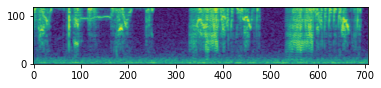

In [13]:
plt.imshow(spec_list[0][:120,:], origin='lower')

In [14]:
subj_list = spec_df.name.values.tolist()

In [15]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')
output_data = enc.fit_transform(np.array(subj_list).reshape((len(subj_list), 1))).toarray()

In [16]:
import itertools
output_data = np.array(list(itertools.chain.from_iterable(itertools.repeat(x, 3) for x in output_data)))

In [17]:
np.unique(output_data, return_counts=True, axis=0)

(array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 array([1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500,


In [18]:
input_list = []
for spec in spec_list:
    spec_h, spec_w = spec.shape
    divided_w = spec_w//3
    for i in range(3):
        s = spec[:, divided_w*i:divided_w*(i+1)]
        input_list.append(np.stack([s, s, s], axis = 2))

In [19]:
input_list = np.array(input_list)

In [20]:
input_list.shape

(21000, 291, 235, 3)

In [21]:
n_samples, n_outputs=output_data.shape
h, w = input_list[0].shape[:2]
print(n_samples, n_outputs, h, w)

21000 14 291 235


In [22]:
input_train, input_test, output_train, output_test = train_test_split(input_list, output_data, test_size = 0.2, 
                                                                      random_state=20, stratify=output_data)

In [23]:
input_train = np.array(input_train)
input_test = np.array(input_test)
output_train = np.array(output_train)
output_test = np.array(output_test)

## make model

In [24]:
clear_session()

In [25]:
model=self_VGG(weights='imagenet')

In [26]:
model_inputs = Input(shape=(h, w, 3))
resized = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear")(model_inputs)
dense_1 = layers.Dense(2048, name='dense1', activation='relu')(model(resized))
dropout_1 = layers.Dropout(0.2)(dense_1)
dense_2 = layers.Dense(2048, name='dense2', activation='relu')(dropout_1)
dropout_2 = layers.Dropout(0.2)(dense_2)
dense_3 = layers.Dense(1024, name='dense3', activation='relu')(dropout_2)
dropout_3 = layers.Dropout(0.2)(dense_3)
model_output = layers.Dense(n_outputs, name='output', activation ='softmax')(dropout_3) # this needs to be changed for both temporal and spectral slices
classifier = Model(model_inputs, model_output)

In [27]:
classifier.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 291, 235, 3)]     0         
_________________________________________________________________
resizing (Resizing)          (None, 224, 224, 3)       0         
_________________________________________________________________
vgg19 (Functional)           (None, 512)               20024384  
_________________________________________________________________
dense1 (Dense)               (None, 2048)              1050624   
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense2 (Dense)               (None, 2048)              4196352   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)             

In [29]:
classifier.compile(loss='categorical_crossentropy', optimizer = Adam(0.00001), metrics=['accuracy'])

In [31]:
results_folder = os.path.abspath('/mnt/cube/kai/results/perceptual_loss')
run_folder = extend_folder(results_folder, '2021_07_14_21_46_52', 'subj_classification', 'imagenet')
with open(os.path.join(run_folder, 'training.log'), 'w') as file:
    file.write('This is a model pretrained on imagenet labels, \n \
               fine tuned on subject classification (Starling), pretrained weights are trainable')

## Fit

In [32]:
patience = 20
batch_size = 32
epochs = 1000

In [33]:
weights_file = os.path.join(run_folder, 'weights-improvement.h5')
callbacks = [EarlyStopping(monitor='val_accuracy', patience=patience, verbose=1),
            ModelCheckpoint(filepath=weights_file, monitor='val_accuracy', save_best_only=True, verbose=0)]

classifier.fit(x = input_train, y = output_train, callbacks=callbacks, epochs=epochs, 
          batch_size=batch_size,validation_split=0.1)

Train on 15120 samples, validate on 1680 samples
Epoch 1/1000
15120/15120 [==============================] - ETA: 0s - loss: 2.1951 - accuracy: 0.2062WARNING:tensorflow:From /home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
15120/15120 [==============================] - 125s 8ms/sample - loss: 2.1951 - accuracy: 0.2062 - val_loss: 1.2763 - val_accuracy: 0.4667
Epoch 2/1000
15120/15120 [==============================] - 131s 9ms/sample - loss: 0.9849 - accuracy: 0.5825 - val_loss: 0.7167 - val_accuracy: 0.6917
Epoch 3/1000
15120/15120 [==============================] - 124s 8ms/sample - loss: 0.6693 - accuracy: 0.7086 - val_loss: 0.5742 - val_accuracy: 0.7464
Epoch 4/1000
15120/15120 [

In [34]:
classifier.load_weights(weights_file)
prediction_test = classifier.predict(input_test)

In [35]:
prediction_logits = np.argmax(prediction_test, axis=1)

In [36]:
output_logits = np.argmax(output_test, axis=1)

### subj classification accuracy

In [37]:
np.mean(prediction_logits==output_logits)

0.8326190476190476

# Inspect clustering

In [28]:
long_list = []
for spec in spec_list:
    long_list.append(np.stack([spec, spec, spec], axis = 2))

In [30]:
long_list = np.array(long_list)

In [29]:
clear_session()

In [31]:
model=self_VGG()

In [32]:
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [33]:
model_inputs = Input(shape=(spec_h, spec_w, 3))
resized = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear")(model_inputs)
classifier = Model(model_inputs, model(resized))

In [34]:
weights_file = os.path.join('/mnt/cube/kai/results/perceptual_loss/2021_07_14_21_46_52/subj_classification/imagenet/weights-improvement.h5')
classifier.load_weights(weights_file, by_name=True)

In [35]:
embeddings = classifier.predict(long_list)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


In [36]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
subj_list_num = le.fit_transform(subj_list)

In [37]:
import umap

UMAP = umap.UMAP(n_neighbors=10, random_state=20)
embeddings_reduced = UMAP.fit_transform(embeddings, y=subj_list_num)

<AxesSubplot:>

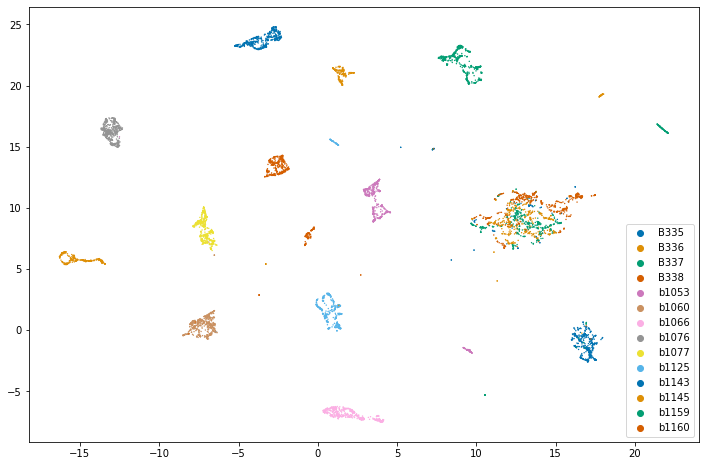

In [38]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x = embeddings_reduced[:,0], y = embeddings_reduced[:,1], 
                    hue = subj_list, s = 2, linewidth = 0, palette = 'colorblind')

# without subj classification fine tuning

In [39]:
clear_session()

In [40]:
model=self_VGG(weights='imagenet')
model_inputs = Input(shape=(spec_h, spec_w, 3))
resized = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear")(model_inputs)
classifier = Model(model_inputs, model(resized))
embeddings = classifier.predict(long_list)
UMAP = umap.UMAP(n_neighbors=10, random_state=20)
embeddings_reduced = UMAP.fit_transform(embeddings, y=subj_list_num)

<AxesSubplot:>

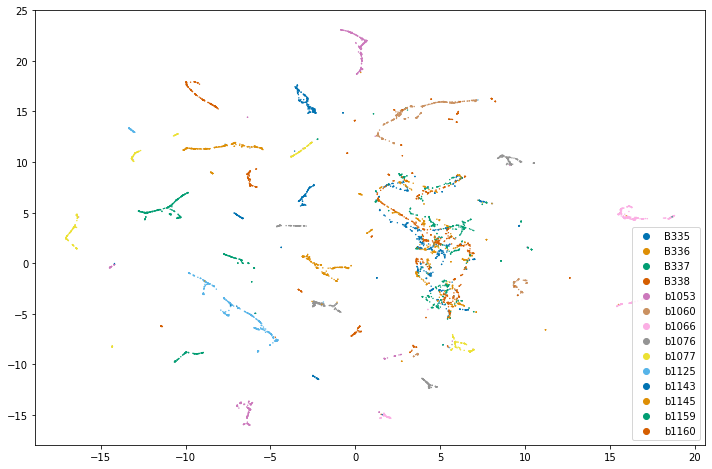

In [41]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x = embeddings_reduced[:,0], y = embeddings_reduced[:,1], 
                    hue = subj_list, s = 2, linewidth = 0, palette = 'colorblind')

# short ones

In [42]:
divided_w = spec_w//3
short_list = []

for spec in spec_list:
    for i in range(3):
        s = spec[:, divided_w*i:divided_w*(i+1)]
        short_list.append(np.stack([s, s, s], axis = 2))
short_list = np.array(short_list)

In [43]:
clear_session()

In [44]:
model=self_VGG()

In [45]:
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [46]:
model_inputs = Input(shape=(spec_h, divided_w, 3))
resized = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear")(model_inputs)
classifier = Model(model_inputs, model(resized))

In [47]:
classifier.load_weights(weights_file, by_name=True)

In [48]:
embeddings = classifier.predict(short_list)

In [49]:
import umap

UMAP = umap.UMAP(n_neighbors=10, random_state=20)
embeddings_reduced = UMAP.fit_transform(embeddings)

subj_list = list(itertools.chain.from_iterable(itertools.repeat(x, 3) for x in subj_list))

<AxesSubplot:>

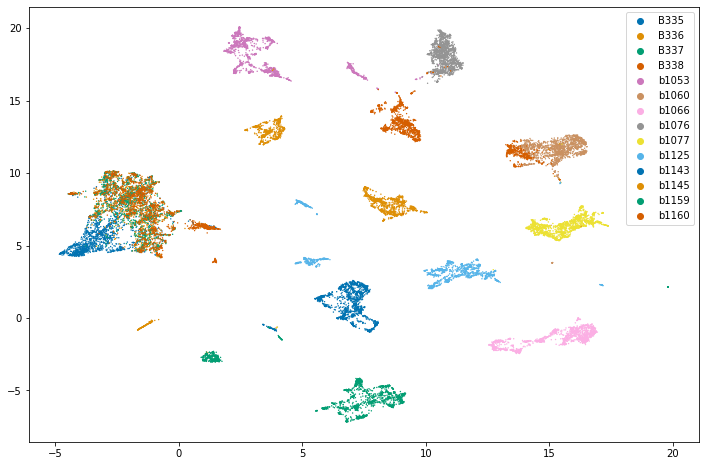

In [50]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x = embeddings_reduced[:,0], y = embeddings_reduced[:,1], 
                    hue = subj_list, s = 2, linewidth = 0, palette = 'colorblind')